In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from tabulate import tabulate

from sklearn import metrics
from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from scipy import interp
from sklearn.model_selection import KFold

import plotly.plotly as py
import plotly.figure_factory as ff

In [51]:
data = pd.read_csv("HM_cohort_wth_LabTest.csv", index_col=0)
data[['p_blood_culture_1', 'rbc_1', 'platelet_1'
      , 'vasopressor_1', 'ventilation_1']] = data[['p_blood_culture_1', 'rbc_1', 'platelet_1'
                                                   , 'vasopressor_1', 'ventilation_1']].fillna(0)


df = pd.DataFrame(data, columns =['gender','p_blood_culture_1', 'rbc_1', 'platelet_1',
                                 'ventilation_1','vasopressor_1', 'rrt',
                                 'age', 
                                 'sofa',
                                 'wbc','hemoglobin','platelet','sodium','potassium','creatinine',
                                 'heart_rate', 'respiration', 'temperature',
                                 'mort_icu'
                                ])

df=df.dropna(axis = 0, how='any')
df['gender'] = df['gender'].str.replace('M','1')
df['gender'] = df['gender'].str.replace('F','0')
X = pd.DataFrame(df,columns =['gender','p_blood_culture_1', 'rbc_1', 'platelet_1',
                                 'ventilation_1','vasopressor_1', 'rrt',
                                 'age', 
                                 'sofa',
                                 'wbc','hemoglobin','platelet','sodium','potassium','creatinine',
                                 'heart_rate', 'respiration', 'temperature',
                                 ])

y = pd.DataFrame(df,columns =['mort_icu'])

In [52]:
n_samples, n_features = X.shape
X = np.array(X)
y = np.ravel(y)



# shuffle and split training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)
classifier = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
coefs_=[]
score =[]
y_tests = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    classifier.fit(X_train, y_train)
    score.append(classifier.score(X_test, y_test).ravel().copy())
    #coefs_.append(classifier.coef_.ravel().copy())

score=np.array(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

#Final Module
classifier.fit(X, y)
y_score = classifier.decision_function(X)
beta = np.array(classifier.coef_)
print("Model:", beta)

# odd ratio
odd_r = np.exp(beta).transpose().ravel()


Accuracy: 0.856 (+/- 0.068)
Model: [[ -2.59120966e-01  -3.36146217e-01   0.00000000e+00   4.01003970e-02
    1.42515531e+00   1.12565469e+00   1.21880077e-01   3.62812787e-03
    2.22298931e-01   6.72430519e-03   0.00000000e+00   9.24768647e-04
   -4.11181510e-02   2.21462412e-01  -3.04336123e-01   6.92001812e-03
    2.87390260e-03  -8.19149802e-04]]


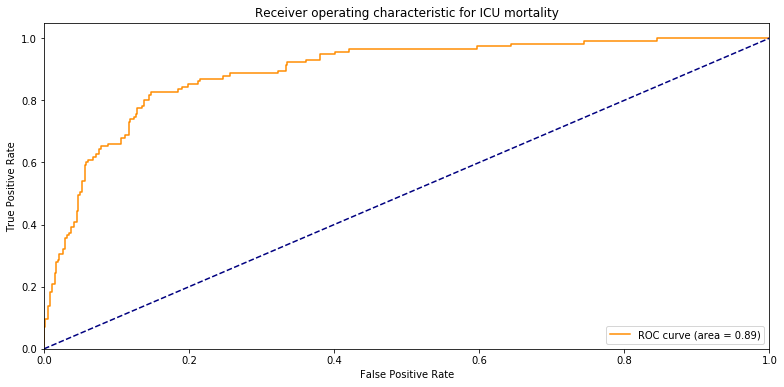

In [53]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#for i in range(n_classes):
fpr, tpr, thresholds = metrics.roc_curve(y, y_score)

roc_auc = auc(fpr, tpr)
plt.figure(figsize=(13,6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for ICU mortality')
plt.legend(loc="lower right")
plt.show()

In [57]:
columns=['Male sex','p_blood_culture_1', 'rbc_1', 'platelet_1','ventilation_1','vasopressor_1', 'rrt',
                  'age','sofa','wbc','hemoglobin','platelet','sodium','potassium','creatinine',
                  'heart_rate', 'respiration', 'temperature']
features = np.asarray(columns).transpose()

#select p_values for the 17 features
tableone=pd.read_csv('tableone_result.csv', index_col=0)
p_value=tableone['0'][np.r_[18,21,24,27,30,33,36,0:8,11,12,16]]

data_matrix = np.column_stack((features,odd_r,p_value))
title = np.asarray(['Features','Odd Ratio','P-value'])
table = np.vstack((title,data_matrix))
print (tabulate(table))

-----------------  ------------------  ------------------
Features           Odd Ratio           P-value
Male sex           0.7717296641883682  0.127
p_blood_culture_1  0.7145186234008161  0.138
rbc_1              1.0                 0.0
platelet_1         1.0409152737363823  0.0
ventilation_1      4.158503659245735   0.0
vasopressor_1      3.082234102371345   0.0
rrt                1.1296186269673165  0.0
age                1.0036347174938838  0.5579999999999999
sofa               1.248944669855609   0.0
wbc                1.0067469640946052  0.075
hemoglobin         1.0                 0.6779999999999999
platelet           1.0009251963771133  0.005
sodium             0.9597157319028081  0.25
potassium          1.2479003409827893  0.006
creatinine         0.7376128959949447  0.019
heart_rate         1.0069440167741754  0.001
respiration        1.0028780362187648  0.001
temperature        0.9991811856093052  0.647
-----------------  ------------------  ------------------
